In [43]:
import numpy as np
import matplotlib.pyplot as plt
import copy
from scipy.optimize import minimize, rosen, rosen_der, curve_fit
from scipy.interpolate import UnivariateSpline
from itertools import product
from numpy import genfromtxt

In [2]:
from qiskit import QuantumCircuit, execute, Aer, ClassicalRegister, QuantumRegister
from qiskit.circuit.library import EfficientSU2
import numpy as np
from qiskit.visualization import plot_histogram, circuit_drawer

In [4]:
n=2

In [5]:
# n-qubit Pauli basis measurement and get data(counts)

def qc_zxy(index_list, Initial_state_circuit):
    n = len(index_list)
    for i in range(n):
        if i == 0:
            qc = QuantumCircuit(n,n)
            qc = qc + Initial_state_circuit
        if index_list[i] == 0:
            qc.h(n-1-i)
        elif index_list[i] == 1:
            qc.p(-np.pi/2,n-1-i)
            qc.h(n-1-i)
        elif index_list[i] == 2:
            i
        if i == n-1:
            for j in range(n):
                qc.measure(j,j)
    return qc

# *** used in sort_data function
# generate product in lexicographic order, requried in sort_data ex, ['000', '001', '010', '011', '100', '101', '110', '111'] 
bin_str = [''.join(p) for p in product('10', repeat=n)]
bin_str.reverse()

def sort_data(counts):
    data = [0]*(2**n)
    for i in range(len(bin_str)):
        if bin_str[i] not in counts:
            data[i] = 0
        else:
            data[i] = counts[bin_str[i]]
    return data

# Measurement on different basis

def for_recursive(number_of_loops, range_list, execute_function, Initial_state_circuit, basis_box_list,
                  current_index=0, iter_list = []):

    if iter_list == []:
        iter_list = [0]*number_of_loops

    if current_index == number_of_loops-1:
        for iter_list[current_index] in range_list[current_index]:
            execute_function(iter_list, Initial_state_circuit, basis_box_list)
    else:
        for iter_list[current_index] in range_list[current_index]:
            for_recursive(number_of_loops, range_list = range_list,execute_function = get_nq_basis, 
                          Initial_state_circuit=Initial_state_circuit, basis_box_list=basis_box_list,
                          current_index = current_index+1, iter_list = iter_list)
    return basis_box_list

def get_nq_basis(index_list, Initial_state_circuit, basis_box_list): # index_list는 밑에 나오는 순서쌍 리스트
    n = len(index_list)
    qc = qc_zxy(index_list, Initial_state_circuit)
    sim = Aer.get_backend('aer_simulator')    
    counts = execute(qc, sim, shots=N_shots).result().get_counts()
    data = sort_data(counts)
    data = np.array(data)
    _Z = data.reshape([2]*n)  # basis 하나 완성
    basis_box_list.append(_Z)
    return



# Caculate expectation values of Pauli basis    

def for_recursive_expectation(number_of_loops, range_list, execute_function, expectation_values_list, basis_box_list,
                              current_index=0, iter_list = []):
    if iter_list == []:
        iter_list = [0]*number_of_loops
    if current_index == number_of_loops-1:
        for iter_list[current_index] in range_list[current_index]:
            execute_function(iter_list, expectation_values_list, basis_box_list)
    else:
        for iter_list[current_index] in range_list[current_index]:
            for_recursive_expectation(number_of_loops, range_list = range_list,execute_function = Calculate_Pauli_Expectation,
                                      expectation_values_list=expectation_values_list, basis_box_list=basis_box_list,
                                      current_index = current_index+1, iter_list = iter_list)
    return expectation_values_list


def Calculate_Pauli_Expectation(index_list, expectation_values_list, basis_box_list):
    # basis_index 얻기
    index_list_copy = index_list.copy()
    for i in range(n):
        if index_list_copy[i] == 0:
            index_list_copy[i] = 1
    index_list_copy.reverse()
    index_list_copy = np.array(index_list_copy)
    basis_index = index_list_copy[0]
    for i in range(1,n):
        basis_index = basis_index + (index_list_copy[i]-1)*3**i

    # egienvalue 나열 만들기 ex) 2qubit -> array[[1,-1],[1,-1]]
    egienvalue_1d_array = np.array([1,-1])
    for i in range(n-1):
        egienvalue_1d_array = np.append(egienvalue_1d_array, egienvalue_1d_array * -1)
    egienvalue_1d_array = egienvalue_1d_array.reshape([2]*n)
    
    # Pauli expectation values 얻기
    S0 = [slice(None,None)]*n # 필요한 axis의 eigenvalue를 바꾸어주기 위해 필요. +1 -> -1 ,  -1 -> +1
    
    # 알맞은 +1, -1 egienvalues를 states에 곱하기
    for i in range(n):
        if index_list[i] == 0:
            S1 = S0.copy()
            S1[i] = 1
            S = tuple(S1)
            egienvalue_1d_array[S] = egienvalue_1d_array[S].dot(-1)
            
    # basis_box_list normalization
    basis_box_list_normalized = basis_box_list.copy()
    for i in range(3**n):
        basis_box_list_normalized[i] = basis_box_list_normalized[i].dot(1/N_shots)
    expectation_value = np.dot(basis_box_list_normalized[basis_index-1].flatten(), egienvalue_1d_array.flatten()) # *** 이전 단계에서 얻은 데이터(basis_box_list_normalized)가 여기서 쓰임.    
    expectation_values_list.append(expectation_value)
    return

In [6]:
# basis_list ex) ['iz', 'xx', 'zi', 'zz'],  P_weight ex) [0.397936, 0.180931, 0.397936, 0.01128], 
# basis_needed ex) [3, 5, 12, 15]   구하기

def basis_to_sequence_number(basis):
    x = list(basis[0])
    x_list = []
    for i in range(n):
        if x[i] == 'i':
            x_list.append(0)
        elif x[i] == 'x':
            x_list.append(1)
        elif x[i] == 'y':
            x_list.append(2)
        elif x[i] == 'z':
            x_list.append(3)    
    x_list.reverse()
    sequence_number = 0
    for i in range(len(x_list)-1,-1,-1):
        sequence_number += x_list[i]*4**i
    return sequence_number

def basis_tup_append_basis_needed(basis_tups):
    for i in range(len(basis_tups)):
        basis_tups[i] = basis_tups[i]+(basis_to_sequence_number(basis_tups[i]),)
    return basis_tups

# 최종적으로 필요한 함수
def basis_tup_sort(basis_tups):
    basis_tups = basis_tup_append_basis_needed(basis_tups)
    sequence_number_list = []
    for i in range(len(basis_tups)):
        sequence_number_list.append(basis_tups[i][2])
    new_basis_list = []
    new_weight_list = []
    new_sequence_number_list =[]
    while basis_tups:
        minimum = basis_tups[0][2]  # arbitrary number in list 
        index = 0
        for i in range(len(sequence_number_list)): 
            if sequence_number_list[i] < minimum:
                minimum = sequence_number_list[i]
                index = i
        new_sequence_number_list.append(minimum)
        sequence_number_list.remove(minimum)
        
        x = list(basis_tups[index])
        x.remove(minimum)
        
        new_basis_list.append(x[0])
        new_weight_list.append(x[1])
        basis_tups.remove(basis_tups[index])
    
    basis_list = new_basis_list 
    P_weight = new_weight_list 
    basis_needed = new_sequence_number_list
    
    return basis_list, P_weight, basis_needed

In [7]:
#Function that calculates expectation value of Hamiltonian
def VQE_q_opt_full_pap(x, P_weight, basis_needed):
    ### Transformation on initial state
    global history
    global itera
    global iter_angle
    global iterarry
    
    itera += 1
    
    xcopy= x.copy()
    xcopy *= 180/np.pi
    xcopy=np.mod(xcopy,360)
    iter_angle.append(xcopy)
    iterarry.append(itera)
    
     
    #State preparation (EfficientSU2, Qiskit)
    parameters = x
    circuit = EfficientSU2(n, reps=1)
    circuit = circuit.assign_parameters(parameters, inplace=False)
    init = circuit + QuantumCircuit(n,n)
    Initial_state_circuit = init

    #Measurement, get data(counts)
    basis_box_list = []
    basis_box_list = for_recursive(number_of_loops = n, range_list = [range(0,3)] * n, execute_function = get_nq_basis,
                                   Initial_state_circuit = Initial_state_circuit, basis_box_list = basis_box_list)
    
    #Caculate expectation values of Pauli
    expectation_values_list = []
    expectation_values_list = for_recursive_expectation(number_of_loops = n, range_list = [range(0,4)] * n,
                                                         execute_function = Calculate_Pauli_Expectation, 
                                                          expectation_values_list = expectation_values_list,
                                                           basis_box_list=basis_box_list)
    #weight sum of expectation values by P_weight (Hamiltonian for each basis)
    expectation_values_needed = []
    for i in range(len(basis_needed)):
        expectation_values_needed.append(expectation_values_list[basis_needed[i]])
    val = np.array(expectation_values_needed).dot(np.array(P_weight))*(1/2)
    history.append([itera] + x.tolist() + [val])
    return(val)

In [8]:
def from_csvfile_to_array(file_csv):
    # file_csv must be string type, ex) 'all_H.csv'
    my_data = genfromtxt(file_csv, delimiter=',', dtype = None, encoding='utf-8-sig')
    all_H = my_data[1:].astype(float)
    name = my_data[0,1:].astype(np.str)
    return all_H, name

#### Make weight list of interest by providing the index in all_H. Input index and all_H data
def make_weight_list(ii, all_H):
    '''
    Returns the distance R, and weight list, P_weight (as a list) from the index ii of Supplementary
    Table 2 of https://www.nature.com/articles/ncomms5213.pdf
    '''
    R = all_H[ii][0]
    P_weight = np.delete(all_H[ii], 0)  # [dat[1], dat[2], dat[3], dat[4], dat[5],dat[6], dat[7], dat[8], dat[9]]
    
    return R, P_weight

In [86]:
#Input Information

#Number of Qubits
n=2
#N_shots, Number of measurements per member (Pauli product) Hamiltonian
N_shots=1000

#input data in tuples 

#basis_tups = [('ii', -3.3893),('ix', -0.1968),('iz', -1.2073),('xi', -0.1968),('xx', 0.3052),('xz', 0.1968),
            #('zi', -1.2073),('zx', 0.1968),('zz', 0.1626)] # H - He, atomic distance 0.7 angstrom
basis_tups = [('ii', -3.5417),('ix', -0.2060),('iz', -1.1552),('xi', -0.2060),('xx', 0.2958),('xz', 0.2060),
            ('zi', -1.1552),('zx', 0.2060),('zz', 0.1791)] # H - He, atomic distance 0.75 angstrom
#basis_tups = [('ii', -3.666),('ix', -0.2145),('iz', -1.1117),('xi', -0.2145),('xx', 0.2853),('xz', 0.2145),
            #('zi', -1.1117),('zx', 0.2145),('zz', 0.1968)] # H - He, atomic distance 0.8 angstrom
#basis_tups = [('ii', -3.8505),('ix', -0.2288),('iz', -1.0466),('xi', -0.2288),('xx', 0.2613),('xz', 0.2288),
            #('zi', -1.0466),('zx', 0.2288),('zz', 0.2356)] # H - He, atomic distance 0.9 angstrom
#basis_tups = [('zz', 0.011280),('zi', 0.397936),('iz', 0.397936),('xx', 0.180931)] # H - H
#measurement basis you will use in order, ex) II,IX,IY,IZ,XI,XX, ... ,ZZ  -->>  0,1,2,3,4,5, ... ,15
# ex) 'iz', 'xx', 'zi', 'zz'  =>   [3, 5, 12, 15]

basis_list, P_weight, basis_needed = basis_tup_sort(basis_tups)

#Or input data by importing data
#all_H, name = from_csvfile_to_array('')
#R, P_weight = make_weight_list(ii, all_H)
#basis_needed = ex) [3, 5, 12, 15] 직접 입력 필요


#you need a theorectical value to compare with results
val = -2.90324307 # R=0.7  #-2.8626207640, R=0.8 H-He
#val = -1.13722138 # H-H


In [87]:
#basis_list, P_weight, basis_needed

In [91]:
cor_rep=0
succ=0
results=[]
itera = 0
prehis=[[0]]
min_val=[]
lamda=[]
save=[]
cor_rep=0
np.random.seed(30)# Seed of the random number. Used to generate the same sequence of random number in every run.

while cor_rep<5:
    itera = 0
    history = []
    cor_rep +=1
    iter_angle=[]
    iterarry=[]
    iter_angle1=[]
    init_parameters = np.pi*np.random.random((4*n, 1))
    init_parameters = [item for sublist in init_parameters for item in sublist]
    res = minimize(VQE_q_opt_full_pap, init_parameters, method ='COBYLA',\
                   args = (P_weight, basis_needed), options = {'maxiter':200,'tol':0.01,'rhobeg':3.14/2})
    history = np.array(history)
    minH=np.min(history[:, -1]) #최소 H    
    if abs(minH-val)<0.05:
        succ += 1
        results.append([history[-1, 0]]+[minH.tolist()]) #이터레이션
        #print(results)
    if cor_rep == 1 or np.min(history[:, -1])<np.min(prehis[:, -1]):
         prehis=copy.deepcopy(history)## find oneof ten min_history

In [92]:
succ

4

In [93]:
res

     fun: -2.8134547
   maxcv: 0.0
 message: 'Optimization terminated successfully.'
    nfev: 66
  status: 1
 success: True
       x: array([ 0.70542769,  1.58746493, -0.05433065,  3.24773959,  0.87154884,
        1.72137301,  1.90044676,  2.89054039])

In [94]:
results=np.array(results)
results[:,1]=np.round(results[:,1],5)
print('mean iteration',round(np.mean(results[:,0])),'mean <H>',round(np.mean(results[:,1]),4),'std <H>',round(np.std(results[:,1]),4),'min <H>',np.min(results[:,1]),'ideal H',round(val,4),\
      'success',succ, 'mean N',round(np.mean(results[:,0]),4),'std N',round(np.std(results[:,0]),4),'mean H - ideal H',round(val-np.mean(results[:,1]),4))

mean iteration 64 mean <H> -2.8573 std <H> 0.0021 min <H> -2.86063 ideal H -2.9032 success 4 mean N 64.25 std N 7.6281 mean H - ideal H -0.046


In [95]:
results=np.array(results)
results[:,1]=np.round(results[:,1],5)
print('mean iteration',round(np.mean(results[:,0])),'mean <H>',round(np.mean(results[:,1]),4),'std <H>',round(np.std(results[:,1]),4),'min <H>',np.min(results[:,1]),'ideal H',round(val,4),\
      'success',succ, 'mean N',round(np.mean(results[:,0]),4),'std N',round(np.std(results[:,0]),4),'mean H - ideal H',round(val-np.mean(results[:,1]),4))

mean iteration 64 mean <H> -2.8573 std <H> 0.0021 min <H> -2.86063 ideal H -2.9032 success 4 mean N 64.25 std N 7.6281 mean H - ideal H -0.046


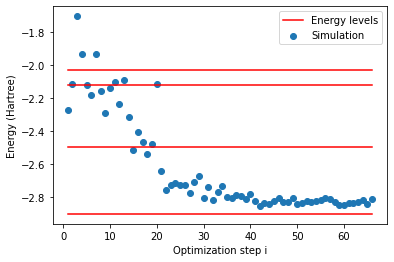

In [189]:
#Energy levels, -2.90324307, -2.49995502, -2.12374055, -2.02802390

plt.scatter(history[:, 0], history[:,-1], label = 'Simulation')
plt.plot([history[0,0], history[-1,0]], [-2.90324307,-2.90324307], 'red', label = 'Energy levels')
plt.plot([history[0,0], history[-1,0]], [-2.49995502,-2.49995502], 'red', label = '')
plt.plot([history[0,0], history[-1,0]], [-2.12374055,-2.12374055], 'red', label = '')
plt.plot([history[0,0], history[-1,0]], [-2.02802390,-2.02802390], 'red', label = '')

plt.legend()
plt.title('')
plt.xlabel('Optimization step i')
plt.ylabel('Energy (Hartree)')
plt.show()

#print('Minimum in simulation:', min(history[:,-1]), '\nTheoretical Minimum: ', val, '\nObjective Function Returns:', res.fun)

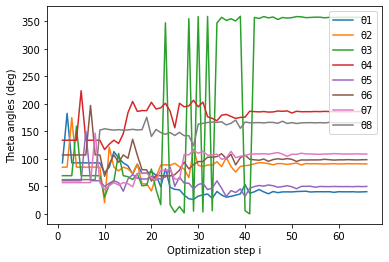

In [194]:
plt.title('')
plt.plot(iterarry,iter_angle)
plt.xlabel('Optimization step i')
plt.ylabel('Theta angles (deg)')
plt.legend(['θ1','θ2','θ3','θ4','θ5','θ6','θ7','θ8'],loc=1)
plt.show()

In [ ]:
#adding codes to caculute the minimal energy at each distance (전체 atomic seperation 0.05 ~ 3.95 angstrom에 대해 계산)

In [100]:
def from_csvfile_to_array(file_csv):
    # file_csv must be string type, ex) 'all_H.csv'
    my_data = genfromtxt(file_csv, delimiter=',', dtype = None, encoding='utf-8-sig')
    all_H = my_data[1:].astype(float)
    name = my_data[0,1:].astype(np.str)
    return all_H, name

#### Make weight list of interest by providing the index in all_H. Input index and all_H data
def make_weight_list(ii, all_H):
    '''
    Returns the distance R, and weight list, P_weight (as a list) from the index ii of Supplementary
    Table 2 of https://www.nature.com/articles/ncomms5213.pdf
    '''
    R = all_H[ii][0]
    P_weight = np.delete(all_H[ii], 0)  # [dat[1], dat[2], dat[3], dat[4], dat[5],dat[6], dat[7], dat[8], dat[9]]
    
    return R, P_weight

In [101]:
#Function that calculates expectation value of Hamiltonian
def VQE_q_opt_full_pap_no_history(x, P_weight, basis_needed):
     
    #State preparation (EfficientSU2, Qiskit)
    parameters = x
    circuit = EfficientSU2(n, reps=1)
    circuit = circuit.assign_parameters(parameters, inplace=False)
    init = circuit + QuantumCircuit(n,n)
    Initial_state_circuit = init

    #Measurement, get data(counts)
    basis_box_list = []
    basis_box_list = for_recursive(number_of_loops = n, range_list = [range(0,3)] * n, execute_function = get_nq_basis,
                                   Initial_state_circuit = Initial_state_circuit, basis_box_list = basis_box_list)
    
    #Caculate expectation values of Pauli
    expectation_values_list = []
    expectation_values_list = for_recursive_expectation(number_of_loops = n, range_list = [range(0,4)] * n,
                                                         execute_function = Calculate_Pauli_Expectation, 
                                                          expectation_values_list = expectation_values_list,
                                                           basis_box_list=basis_box_list)
    #weight sum of expectation values by P_weight (Hamiltonian for each basis)
    expectation_values_needed = []
    for i in range(len(basis_needed)):
        expectation_values_needed.append(expectation_values_list[basis_needed[i]])
    val = np.array(expectation_values_needed).dot(np.array(P_weight))*(1/2)
    
    return(val)

In [102]:
all_H, name = from_csvfile_to_array('all_H.csv') # H - He, atomic distance (angstrom)

<ipython-input-100-28b568051310>:5: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  name = my_data[0,1:].astype(np.str)


In [103]:
len(all_H)

79

In [136]:
#Number of Qubits
n=2
#N_shots, Number of repetition for measurement per a basis - (Pauli product) Hamiltonian
N_shots=1500
#you need a theorectical value to compare with results

#rep = len(all_H)
rep = 69
min_E = []

for i in range(rep):
    R, P_weight = make_weight_list(i, all_H)

    #input data in tuples
    basis_tups = [('ii', P_weight[0]),('ix', P_weight[1]),('iz', P_weight[2]),('xi', P_weight[3]),('xx', P_weight[4]),
                  ('xz', P_weight[5]), ('zi', P_weight[6]),('zx', P_weight[7]),('zz', P_weight[8])] 
                  # H - He, atomic distance in angstrom
    basis_list, P_weight, basis_needed = basis_tup_sort(basis_tups)

    np.random.seed(30)# Seed of the random number. Used to generate the same sequence of random number in every run.

    init_parameters = np.pi*np.random.random((4*n, 1))
    init_parameters = [item for sublist in init_parameters for item in sublist]
    res = minimize(VQE_q_opt_full_pap_no_history, init_parameters, method ='COBYLA',\
                    args = (P_weight, basis_needed), options = {'maxiter':100,'tol':0.001,'rhobeg':3.14/2})
    min_E.append(res.fun)    
#min_E

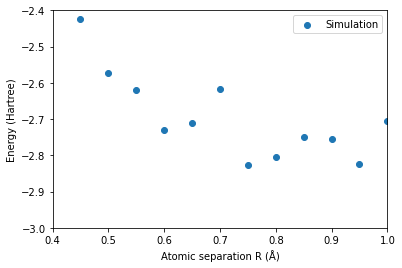

In [139]:
x = np.arange(1,80) * 0.05
plt.scatter(x, min_E_0, label = 'Simulation')
plt.xlim(0.4,1)
plt.ylim(-3,-2.4)
plt.legend()
plt.title('')
plt.xlabel('Atomic separation R (Å)')
plt.ylabel('Energy (Hartree)')
plt.show()

In [ ]:
from matplotlib.pyplot import figure
figure(figsize=(8, 6), dpi=80)

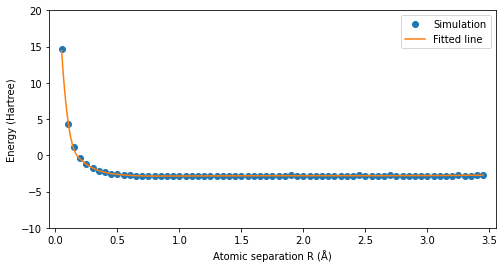

In [256]:
x = np.arange(1,70) * 0.05
y = min_E_1

f = UnivariateSpline(x, y, s=0.5)

# calculate new x's and y's
x_new = np.linspace(x[0], x[68], 1000)
y_new = f(x_new)

plt.plot(x,y,'o', label = 'Simulation')
plt.plot(x_new, y_new, label = 'Fitted line')
plt.xlim([x[0]-0.1, x[-1] + 0.1 ])
plt.ylim(-10,20)
plt.legend()
plt.xlabel('Atomic separation R (Å)')
plt.ylabel('Energy (Hartree)')

plt.rcParams["figure.figsize"]= 8,4 #???

plt.show()

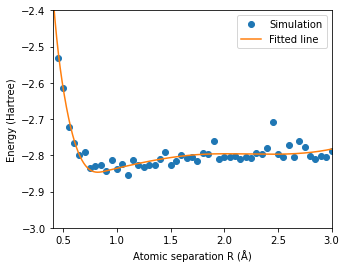

In [287]:
x = np.arange(1,70) * 0.05
y = min_E_1

f = UnivariateSpline(x, y, s = 0.5)

# calculate new x's and y's
x_new = np.linspace(x[0], x[68], 1000)
y_new = f(x_new)

plt.plot(x,y,'o', label = 'Simulation')
plt.plot(x_new, y_new, label = 'Fitted line')
plt.xlim(0.4,3)
plt.ylim(-3,-2.4)
plt.legend()
plt.xlabel('Atomic separation R (Å)')
plt.ylabel('Energy (Hartree)')

plt.rcParams["figure.figsize"]= 4,4 #???
plt.show()